In [1]:
import torch
import os
import os
import pandas as pd
import pyBigWig
import pysam

from enformer_pytorch import from_pretrained
from enformer_pytorch.finetune import HeadAdapterWrapper
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
import seaborn as sns
from enformer_pytorch.data import str_to_one_hot

In [2]:
torch.cuda.is_available()

True

In [3]:
def get_target_from_bigwig(data_folder, bigwig_files, chr_name, start, end, n_bins=896, clip_pct=99.9):
    target = []
    
    for bigwig_file in bigwig_files:
        bigwig_file = data_folder + bigwig_file
        bw = pyBigWig.open(bigwig_file)
        
        try:
            values = bw.stats(chr_name, start, end, nBins=n_bins, type="sum")
            bw.close()
            values = np.array(values, dtype=float)
        except Exception as e:
            print(f"Error getting values for {chr_name}:{start}-{end}: {e}")
            values = np.zeros(n_bins)
        
        # Replace NaN values with zeros
        values = np.nan_to_num(values, nan=0.0)
        values = np.log1p(values)

        # optional clipping of extreme outliers
        if clip_pct is not None:
            cap = np.percentile(values, clip_pct)
            if np.isfinite(cap) and cap > 0:
                values = np.minimum(values, cap)

        target.append(values)
        
    target = np.stack(target, axis=1)  # shape: (n_bins, num_tracks)
    return target

In [4]:
# center each region to length L and filter out-of-bound regions
fa_path = '/home/chent9/projects/enformer-tf/data/genome.fa' 
data_folder = "/home/chent9/Datasets/impute_H3K27ac_downloads"
bigwig_files = ["/CS13_H3K27ac.mean.pval.bw", "/CS14_H3K27ac.mean.pval.bw", "/CS15_H3K27ac.mean.pval.bw", "/CS17_H3K27ac.mean.pval.bw","/impute_CS20-12104_H3K27ac.pval.signal.bigWig"]

# open fasta (requires pysam)
f = pysam.FastaFile(fa_path)

def fetch_seq(chrom, mutation_start, mutation_end, center, seq_L, ref, alt):
    assert int((mutation_start + mutation_end) // 2) == center, "Center does not match mutation positions"
    # ref_from_fa = f.fetch(chrom, mutation_start, mutation_end).upper()
    # assert ref_from_fa == ref, f"Reference allele mismatch: expected {ref}, got {ref_from_fa}"

    seq_half = seq_L // 2
    seq_start = center - seq_half
    seq_end = seq_start + seq_L

    ref_seq = f.fetch(chrom, seq_start, seq_end).upper()
    # apply mutation
    assert ref_seq[seq_half:seq_half+1] == ref, f"Reference allele at center does not match: expected {ref}, got {ref_seq[seq_half:seq_half+1]}"
    alt_seq = ref_seq[:seq_half] + alt + ref_seq[seq_half+1:]

    key_name = f"{chrom}:{center}_{ref}>{alt}"
    
    return {key_name + '|ref': ref_seq,
            key_name + '|alt': alt_seq}

In [9]:
# Given a specific variant with chr, position, ref, and alt alleles, e.g., chr1:209827887_C>T

chrom = 'chr1'
mutation_start = 209827887
mutation_end = 209827887+1
ref_allele = 'C'
alt_allele = 'T'


seq_L = 196608
effective_L = 114688
effe_half = effective_L // 2

# compute centered window
center = int((mutation_start + mutation_end) // 2)
effe_start = center - effe_half
effe_end = effe_start + effective_L

seqs = fetch_seq(chrom, mutation_start, mutation_end, center, seq_L, ref_allele, alt_allele)
target = get_target_from_bigwig(
    data_folder=data_folder,
    bigwig_files=bigwig_files,
    chr_name=chrom,
    start=effe_start,
    end=effe_end,
    n_bins=effective_L//128,
    clip_pct=99.9
)

data = {}
data['chrom'] = chrom
data['target_start'] = effe_start
data['target_end'] = effe_end
data['alt_pos'] = center
data['alt_info'] = f"{ref_allele}>{alt_allele}"
data['target'] = target
data['seqs'] = seqs
data

{'chrom': 'chr1',
 'target_start': 209770543,
 'target_end': 209885231,
 'alt_pos': 209827887,
 'alt_info': 'C>T',
 'target': array([[3.55423314, 3.65830814, 4.03424051, 3.51541855, 4.27109508],
        [3.26774978, 3.38308945, 3.78187575, 3.2643175 , 3.90358753],
        [3.10949839, 3.20451891, 3.43906169, 3.09967553, 3.96366626],
        ...,
        [3.95928824, 4.40472947, 4.21253236, 3.968323  , 3.96556377],
        [3.77954249, 4.20129432, 3.88884899, 3.71362696, 3.73504715],
        [3.59172407, 3.93821742, 3.77724114, 3.48725272, 3.36072257]]),
 'seqs': {'chr1:209827887_C>T|ref': 'CACCAAGAAGGACAAAGGATTGGGAAGGAGAGACTGGCTTCTCCTTTTAAGGATGTGTCCCAACATTGAAACCAAAACTAAAGATACAACAAAAAAGAGAAAACCACAGGCCAATATCCCTGATGAACACAGATGCAAAAATCCTCAACAAAATACTAGCAAACAGAGCTCAACAACATTTTAAAGGATCATTCATTATGATCAAGTAGGATTCATCTTCAAGATGCAAGGATGGTTCAACATAAGCAAATCAATAAATGTGATACATCACATCAACAGAATCAAAGGCAAAAATATATAATCATTTCAGTAGATGATGAAAAAGCATTTGGTAAAATGCAATATCCCTTCATAATAAAAACCCTCAACAAATTGGGTATAGAAGGGATATACCTCAACATCA

In [6]:
# load model
num_tracks = 5
model_name = 'H3K27ac_batchsize_4_lr1e-5_clip0.5_noamp_chromsplit811_log1p_1'
results_folder = '/home/chent9/projects/enformer-pytorch/results'

pretrained = 'EleutherAI/enformer-official-rough'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enformer = from_pretrained(pretrained)
model = HeadAdapterWrapper(enformer=enformer, num_tracks=num_tracks, post_transformer_embed=False).to(device)
model_path = os.path.join(results_folder, model_name, 'model', 'best.pt')
ckpt = torch.load(model_path, map_location=device)
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [10]:
# target = torch.from_numpy(target).float()
preds_list = []
batch_seqs = []
model.eval()
with torch.no_grad():
    for seq_name, seq_str in seqs.items():
        seq_one_hot = str_to_one_hot(seq_str)
        batch_seqs.append(seq_one_hot)
    # Stack the batch sequences into a tensor
    batch_seqs = torch.stack(batch_seqs)  # Shape: [batch_size, seq_len, 4]
    batch_seqs = batch_seqs.to(device)
    # target = target.to(device)
    preds = model(batch_seqs)  # Shape: [batch_size, num_bins, num_tracks]

In [12]:
preds_cpu = preds.detach().cpu().numpy()
# target_cpu = target.detach().cpu().numpy()
preds_ref, preds_alt = preds_cpu[0], preds_cpu[1]

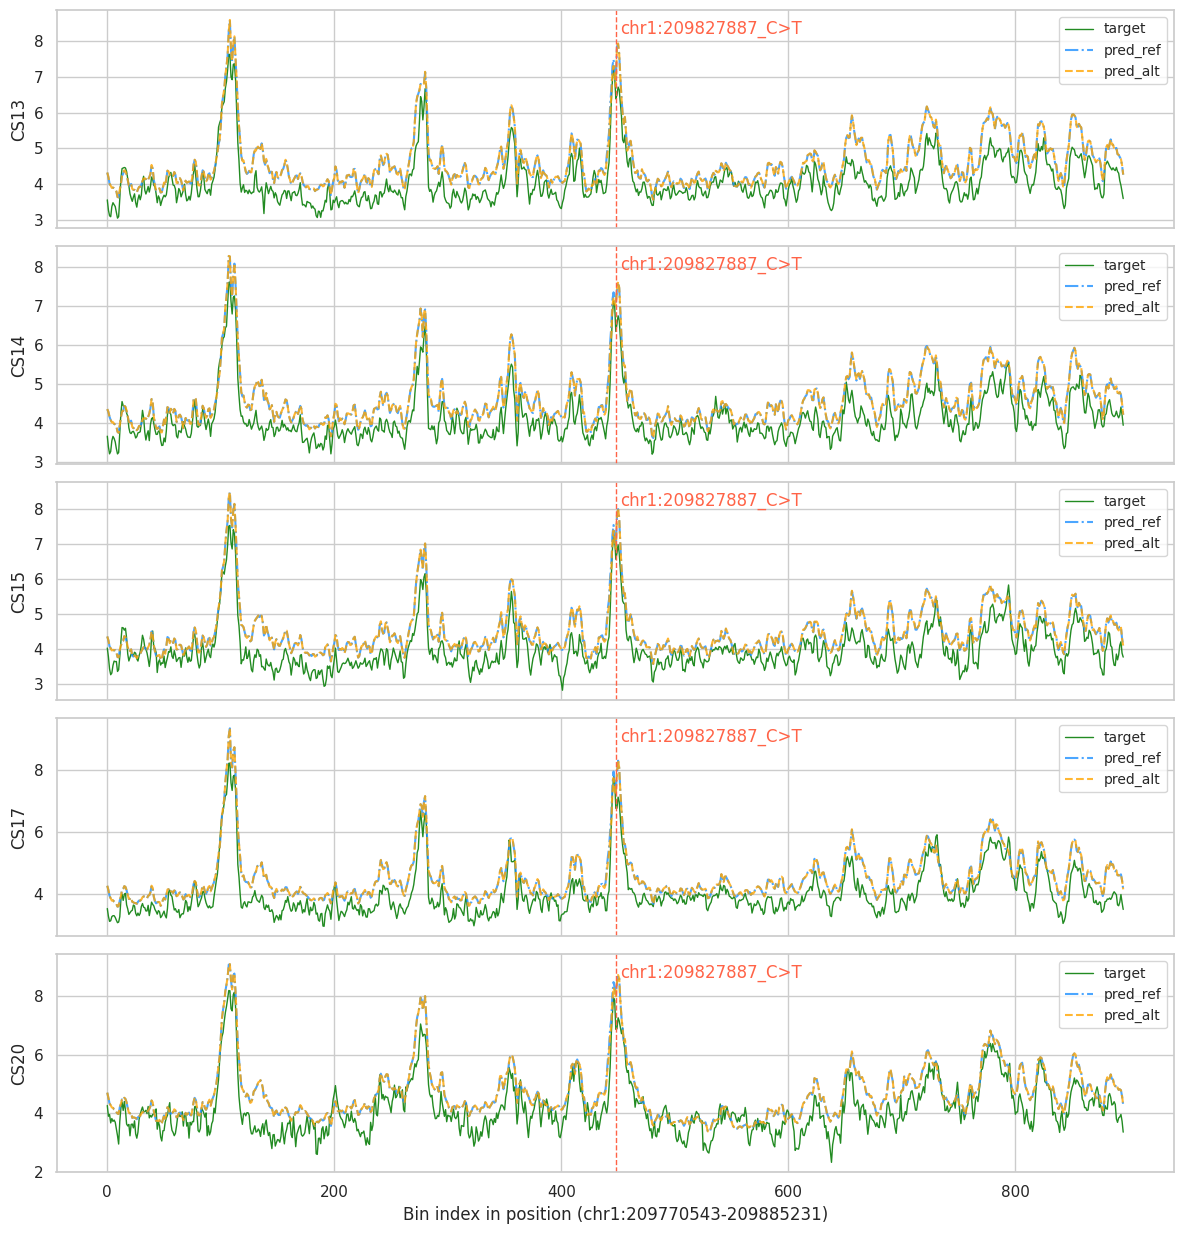

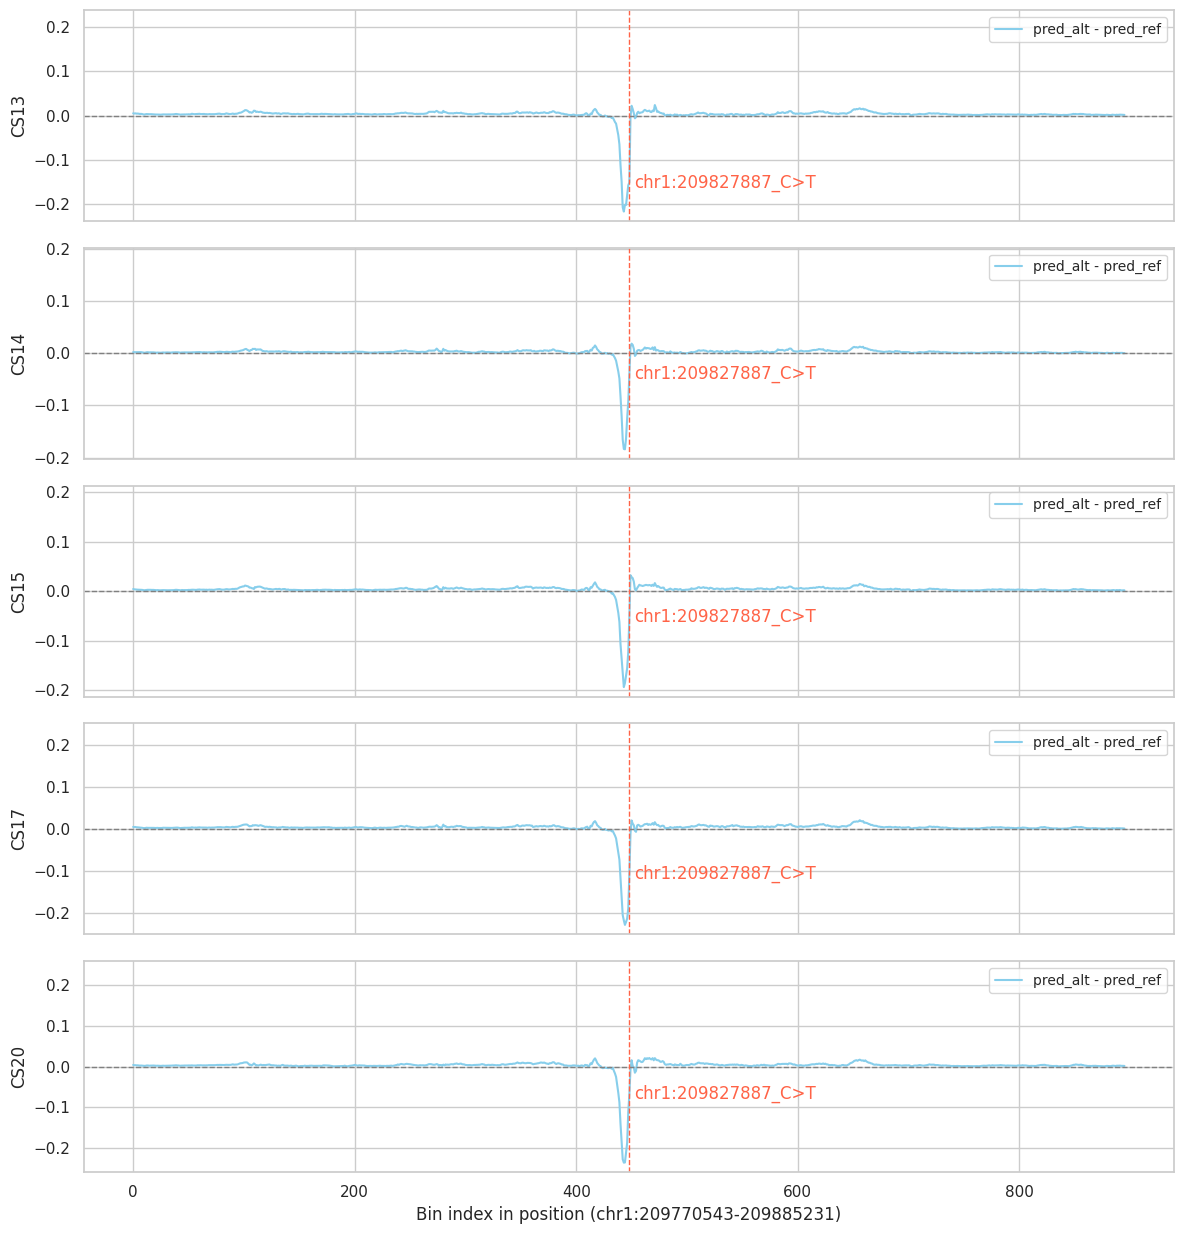

In [46]:
# plot target, preds_ref, preds_alt and mark variant with allele string; then plot their difference
TRACKS_5 = ['CS13','CS14','CS15','CS17','CS20']

num_bins, num_tracks = target.shape
center_bin = num_bins // 2
x = np.arange(num_bins)
variant_label = f"{chrom}:{center}_{ref_allele}>{alt_allele}"
seq_position = f"{chrom}:{effe_start}-{effe_end}"

sns.set(style="whitegrid")

# Figure 1: target, preds_ref, preds_alt
fig, axes = plt.subplots(num_tracks, 1, figsize=(12, 2.5 * num_tracks), sharex=True)
if num_tracks == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(x, target[:, i], label="target", color="forestgreen", lw=1)
    ax.plot(x, preds_ref[:, i], label="pred_ref", linestyle="dashdot", color="dodgerblue", alpha=0.8)
    ax.plot(x, preds_alt[:, i], label="pred_alt", linestyle="dashed", color="Orange", alpha=0.8)
    ax.axvline(center_bin, color="tomato", linestyle="--", lw=1)
    ymax = np.nanmax(np.stack([target[:, i], preds_ref[:, i], preds_alt[:, i]]))
    ax.annotate(variant_label, xy=(center_bin, ymax), xytext=(center_bin + max(3, num_bins // 200), ymax),
                color="tomato", va="top")
    ax.set_ylabel(TRACKS_5[i] if i < len(TRACKS_5) else f"track {i+1}")
    ax.legend(loc="upper right", fontsize="small")

axes[-1].set_xlabel(f"Bin index in position ({seq_position})")
plt.tight_layout()
plt.show()

# Figure 2: difference (alt - ref)
diff = preds_alt - preds_ref

fig, axes = plt.subplots(num_tracks, 1, figsize=(12, 2.5 * num_tracks), sharex=True)
if num_tracks == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(x, diff[:, i], label="pred_alt - pred_ref", color="skyblue")
    ax.axhline(0, color="gray", linestyle="--", lw=1)
    ax.axvline(center_bin, color="tomato", linestyle="--", lw=1)
    max_abs = np.nanmax(np.abs(diff[:, i]))
    if np.isfinite(max_abs) and max_abs > 0:
        pad = max_abs * 0.1
        ax.set_ylim(-max_abs - pad, max_abs + pad)
    else:
        ax.set_ylim(-1, 1)
    # annotate at center bin value
    ax.annotate(variant_label, xy=(center_bin, diff[center_bin, i]),
                xytext=(center_bin + max(3, num_bins // 200), diff[center_bin, i]),
                color="tomato", va="center")
    ax.set_ylabel(TRACKS_5[i] if i < len(TRACKS_5) else f"track {i+1}")
    ax.legend(loc="upper right", fontsize="small")

axes[-1].set_xlabel(f"Bin index in position ({seq_position})")
plt.tight_layout()
plt.show()